 # Лекционная часть

In [1]:
import torch
from torch import nn
import numpy as np
from matplotlib import pyplot as plt

## Pooling

Pooling это по сути еще виды свертки, average pooling - свертка матрицей из значений 1/количество элементов в ядре (в результате свертки получаем среднее значение окна) и еще с несколькими модификациями (об этом ниже), для max pooling - свертка возвращает максимальное значение окна

Пулинги используются для:

- Уменьшения размерности признаков
- Приведения признаков к одному размеру в нейронных сетях со сверточными слоями, так как в зависимости от размеров фото размеры признаков будут также разными (для этого используется AdaptivePooling, который проходится по матрице с таким окном, чтобы выходной размер был тем, что определен заранее) 

### Задача: визуализировать пулинг фото при помощи AvgPool2d, MaxPool2d

*Обратите внимание на порядок измерений в фото и в тензоре, подающемуся в слой PyTorch,*

*([height, width, num_channels] и [batch_size, num_channels, height, width] соответственно)*

*а также на тип данных тензора*

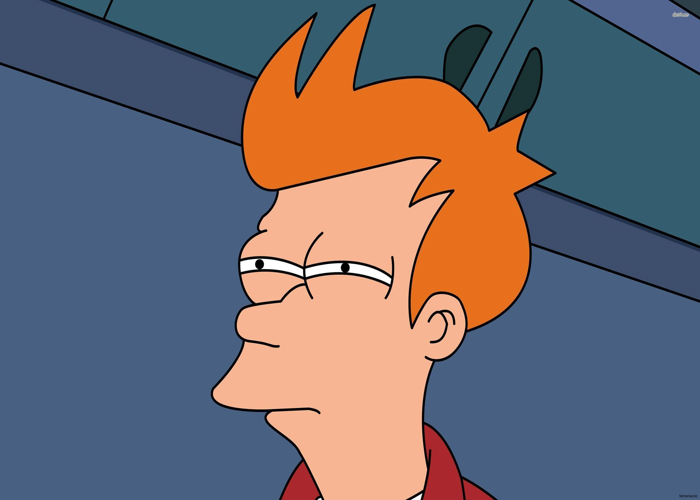

In [57]:
from PIL import Image
import requests
from io import BytesIO

image_url = 'https://i.pinimg.com/originals/5d/c1/5a/5dc15a58073122dfbb1db83934e49fdc.jpg'

response = requests.get(image_url)
img = Image.open(BytesIO(response.content))
img = img.resize((700, 500))
img

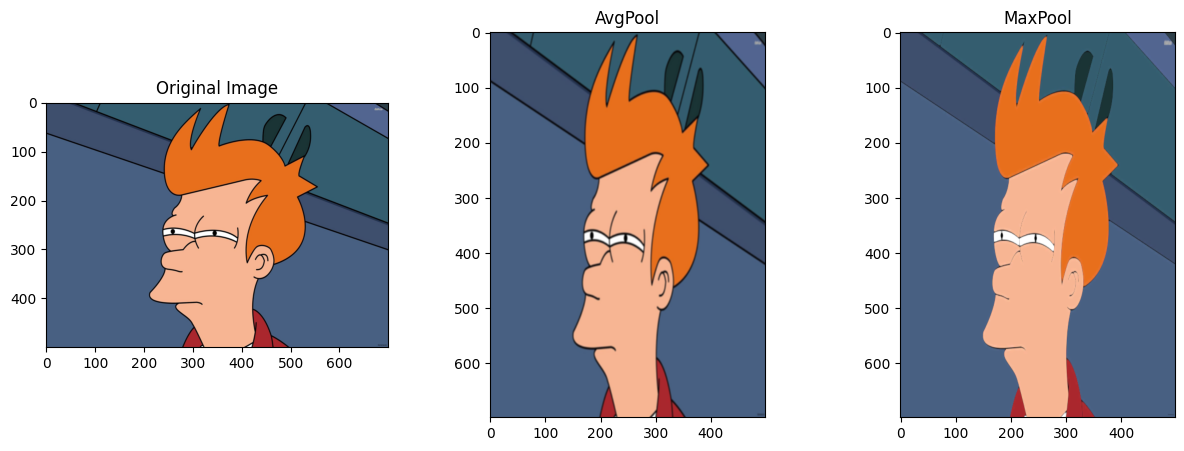

In [73]:
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.Resize((700, 500)),
    transforms.ToTensor(),
])

img_tensor = transform(img)

avg_pool = nn.AvgPool2d(kernel_size=3, stride=1, padding=0)
max_pool = nn.MaxPool2d(kernel_size=3, stride=1, padding=0)

avg_pool_output = avg_pool(img_tensor.unsqueeze(0))
max_pool_output = max_pool(img_tensor.unsqueeze(0))

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(img)
ax[0].set_title("Original Image")
ax[1].imshow(avg_pool_output.squeeze().permute(1,2,0))
ax[1].set_title("AvgPool")
ax[2].imshow(max_pool_output.squeeze().permute(1,2,0))
ax[2].set_title("MaxPool")
plt.show()


### Задача: сравните результат работы AvgPool2d и Conv2d с ядром, которое будет совершать аналогичную операцию

*Чтобы Conv2d выводил тот же результат, кроме кастомного ядра нужно будет поставить параметр groups=3, и изменить параметр stride*

groups - группировка каналов, по умолчанию равен 1 - тогда при свертке агрегируются значения со всех каналов, а если значение будет равно количеству каналов - агрегация будет сделана на каждом канале независимо от других



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


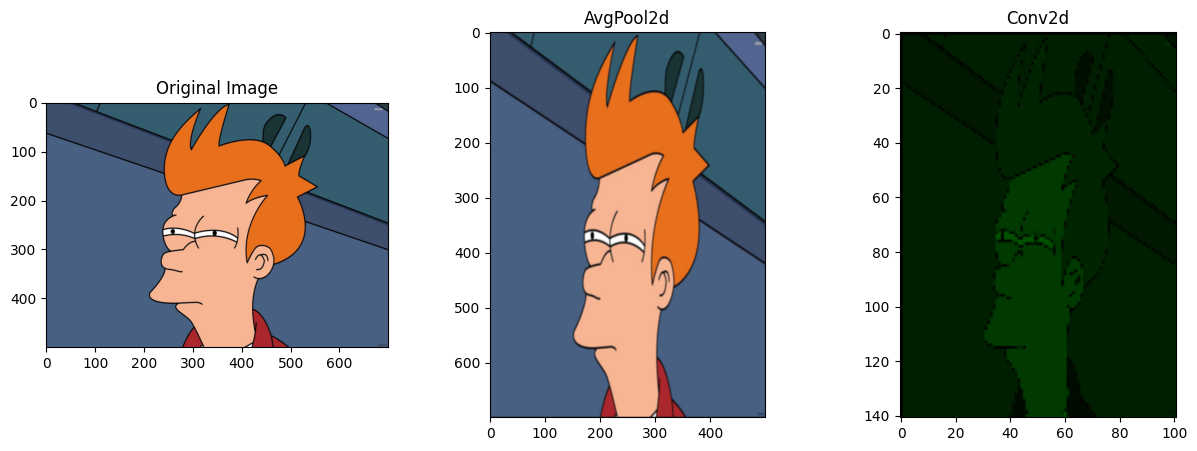

In [76]:
avg_pool = nn.AvgPool2d(kernel_size=3, stride=1, padding=1)
avg_pool_output = avg_pool(img_tensor.unsqueeze(0))

custom_conv = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=1, stride=5, padding=1, groups=3, bias=False)
conv_output = custom_conv(img_tensor.unsqueeze(0))

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(img)
ax[0].set_title("Original Image")
ax[1].imshow(avg_pool_output.squeeze().permute(1,2,0))
ax[1].set_title("AvgPool2d")
ax[2].imshow(conv_output.detach().cpu().squeeze().permute(1,2,0))
ax[2].set_title("Conv2d")
plt.show()

### Задача: используйте AdaptiveAvgPooling2d для приведения фото к размеру 200 на 200, визуализируйте

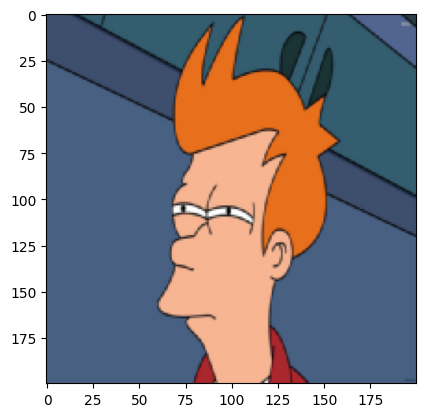

In [9]:
adaptive_avg_pool = torch.nn.AdaptiveAvgPool2d((200, 200))
output_tensor = adaptive_avg_pool(img_tensor.unsqueeze(0))

output_img = transforms.ToPILImage()(output_tensor.squeeze())
plt.imshow(output_img)
plt.show()

## Развитие архитектур сверточных сетей

За основу взята статья: https://habr.com/ru/post/511372/

### LeNet-5 (1998 год)

![image.png](attachment:image.png)

Появилась аж в 1998 году! Была предназначена для распознавания рукописных букв и цифр. Под subsampling (понижение размерности) здесь подразумевается pooling-слой.

Сейчас эта архитектура имеет только историческую значимость. Подобную архитектуру легко имплементировать «ручками» в любом современном фреймворке для глубокого обучения.

Архитектура:

CONV 5x5, stride = 1

POOL 2x2, stride = 2

CONV 5x5, stride = 1

POOL 5x5, stride = 2

FC (120, 84)

FC (84, 10)

### Популяризация

Хорошим толчком и показателем развития архитектур/приемов CNN является The ImageNet Large Scale Visual Recognition Challenge (ILSVRC) - на большом датасете ImageNet ресерчеры сравнивают качество и эффективность на задаче классификации. 

![image.png](attachment:image.png)

По оси x — года и алгоритмы (с 2012 года — сверточные нейронные сети).

По оси y — процент ошибок на выборке из top-5 error.

Top-5 error — это способ оценивания модели: модель возвращает некое распределение вероятностей и если среди топ-5 вероятностей есть истинное значение (метка класса) класса, то ответ модели считается правильным. Соответственно, (1 — top-1 error) — это всем знакомая точность (accuracy).

### AlexNet (2012 год)

![image.png](attachment:image.png)

Картинка не дублируется. Так изображена архитектура, потому что архитектура AlexNet тогда не влезала на одно устройство GPU, поэтому «половина» сети работала на одной GPU, а вторая — на другой.

Появилась в 2012 году. С нее и начался прорыв в том самом ILSVRC — она победила все state-of-the-art модели того времени. После этого люди поняли, что нейронные сети действительно работают :)

Архитектура более конкретно:

![image.png](attachment:image-2.png)

Если приглядеться на архитектуру AlexNet, то можно увидеть, что за 14 лет (с появления LeNet-5) не произошло почти никаких изменений, кроме кол-ва слоев.

Важно:

- Мы берем нашу исходную картинку 227x227x3 и понижаем ее размерность (по высоте и ширине), но увеличиваем кол-во каналов. Такая часть архитектуры «кодирует» изначальное представление объекта (encoder).
- Впервые была применена функция активации ReLU.
- 60 миллионов обучаемых параметров.
- Основная часть обучаемых параметров приходится на полносвязные слои.

Примечания:

- Local Response Norm — это способ нормализации, который использовался в сетях того времени. Сейчас используют batch-normalization.
- Запись вида FC 4096 означает, что полносвязный (Fully-connected) слой имеет 4096 выходных нейронов.
- Запись вида Max Pool 3x3s2 означает, что слой пулинга имеет фильтр 3x3, шаг = 2.
- 96 в записи Conv 11x11s4, 96 означает выходное количество каналов у слоя

### VGGNet (2014 год)

![image.png](attachment:image-2.png)

Две версии — VGG16 и VGG19. Основная идея — использовать вместо больших сверток (11x11 и 5x5) маленькие свертки (3x3). Интуиция в использовании больших сверток простая — мы хотим получать больше информации от соседних пикселей, но гораздо лучше использовать маленькие фильтры чаще.

И вот почему:

- Каждый последующий слой свертки обладает информацией о предыдущем. И чем сильнее мы углубляемся, тем больше информации последний сверточный слой содержит о первом (receptive field). Т.е. мы добились того, чего хотели добиться большими свертками, но в малом количестве.
- Мы слабее уменьшаем размерность нашего изображения => можем применять больше сверток.
Больше сверток — больше активаций, больше активаций — больше нелинейности, а нелинейность — это как раз то, чего мы добиваемся.

Сеть имеет 138 миллионов обучаемых параметров в вариации 16-ти слоев и 143 миллиона параметров в вариации 19-ти слоев.

Примерная реализация VGG16

In [ ]:
class VGG16(nn.Module):
    
    def __init__(
            self, 
            num_classes: int = 1000, 
            dropout: float = 0.5,
            ):
        
        super().__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x
    
model = VGG16()
num_parameters = sum(p.numel() for p in model.parameters())
print(f'Количество параметров: {num_parameters:_}')


Количество параметров: 138_357_544


Удобный способ использовать подобные архитектуры (в том числе с предобученными весами) - timm

In [ ]:
import timm

timm.list_models('vgg*')

['vgg11',
 'vgg11_bn',
 'vgg13',
 'vgg13_bn',
 'vgg16',
 'vgg16_bn',
 'vgg19',
 'vgg19_bn']

In [ ]:
model = timm.create_model('vgg16')
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Можно указать pretrained=True для загрузки модели с готовыми весами, num_classes для указания, сколько классов должна выдавать модель, in_chans в случае, если фото в вашем датасете не 3-канальные, features_only=True если вы хотите просто извлечь признаки

https://timm.fast.ai/create_model

In [ ]:
# Пример
# timm.create_model('vgg11', pretrained=True, in_chans=1)

### GoogleNet (2014 год)

![image.png](attachment:image.png)

Красные кружочки — это так называемый Inception module.

Давайте взглянем на него поближе:

![image.png](attachment:image-2.png)

Мы берем карту признаков (feature map) с предыдущего слоя, применяем к ней какое-то количество сверток с разными фильтрами, потом конкатенируем полученное. Интуиция простая: мы хотим получить различные представления нашей карты признаков, используя фильтры разных размеров. Свертки 1x1 используются для того, чтобы не так сильно наращивать кол-во каналов после каждого такого inception-блока. Т.е. когда у карты признаков большое кол-во каналов, и хотят уменьшить это кол-во, не изменяя высоту и ширину карты признаков, используют свертку размерности 1x1.

Также в сети присутствуют три блока-классификатора, вот так выглядит один из них (тот что справа для нас):

![image.png](attachment:image-3.png)

С помощью такой конструкции градиент «лучше» доходит от выходных слоев до входных во время обратного распространения ошибки.

Зачем нужны еще два лишних выхода сети? Дело все в так называемой проблеме затухающего градиента (vanishing gradient problem):

Суть в том, что при выполнении обратного распространения ошибки градиент банально стремится к нулю. Чем глубже сеть — тем она более подвержена этому явлению. Почему так происходит? Когда мы выполняем backward pass, мы идем от выхода ко входу, вычисляя градиенты сложных функций. Производная сложной функции (chain rule) — это, по сути, умножение. И вот так, умножая какие-то значения по пути от выхода ко входу, мы встречаем числа, которые близки к нулю, и, как следствие, веса нейронной сети практически не обновляются. 

Частично это проблема функций активаций типа sigmoid, у которых выход лежит в каком-то фиксированном диапазоне. Ну и частично эта проблема решается путем использования функции активации ReLu. Почему частично? Потому что никто не дает гарантии на значения обучаемых параметров и представления входного объекта во всех картах признаков.

Важно:

- Сеть имеет 22 слоя (это чуть больше, чем имеет предыдущая сеть).
- Число обучаемых параметров равно пяти миллионам, что в разы и разы меньше, чем у предыдущих двух сетей.
- Появление сверток 1x1.
- Используются Inception блоки.
- Вместо полносвязных слоев теперь свертки 1x1, которые понижают глубину и, как следствие, понижают размерность полносвязных слоев и слой global average pooling.
- Архитектура имеет 3 выхода (итоговый ответ взвешивается).

### ResNet (2015 год)

![image.png](attachment:image-2.png)

Основным новшеством стало большое количество слоев и, так называемые, residual блоки. Эти блоки используются в качестве борьбы с проблемой затухающего градиента. Связь между такими residual-блоками называется shortcut (стрелочки на картинке). Теперь по этим шорткатам градиент и будет доходить до всех нужных параметров, тем самым обучая сеть :)   

Важно:

- Вместо полносвязных слоев — average global pooling (для каждого выходного канала берется среднее).
- Residual-блоки.
- Сеть превзошла человека в распознавании образов на датасете ImageNet (top-5 error).
- Впервые использован batch-normalization.
- Используется техника инициализации весов (интуиция: из определенной инициализации весов сеть сходится (обучается) быстрее и лучше).
- Максимальная глубина — 152 слоя!

Реализация residual блока очень проста:

In [ ]:
class ResidualBlock(torch.nn.Module):
    def __init__(self, module):
        self.module = module

    def forward(self, inputs):
        return self.module(inputs) + inputs

Дальнейшее развитие нейронок в области computer vision - to be continued

### Задача: нарисовать heatmapы карт признаков, создаваемых при помощи предобученной resnet

*Модель, созданная в timm с параметром features_only=True будет возвращать список карт признаков на разной глубине*

*Для визуализации все каналы признаков нужно будет усреднить*

In [67]:
import timm

model = timm.create_model('resnet18', pretrained=True, features_only=True)

features = model(img_tensor.unsqueeze(0))

In [68]:
for x in features:
    print(x.shape)

torch.Size([1, 64, 350, 250])
torch.Size([1, 64, 175, 125])
torch.Size([1, 128, 88, 63])
torch.Size([1, 256, 44, 32])
torch.Size([1, 512, 22, 16])


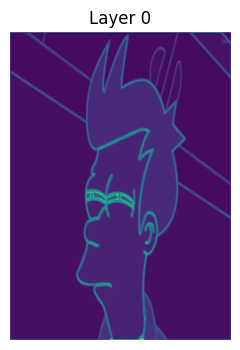

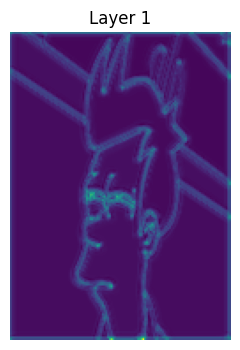

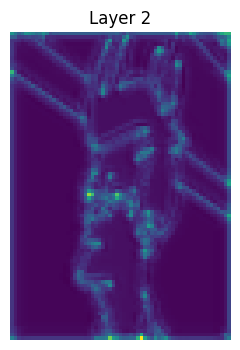

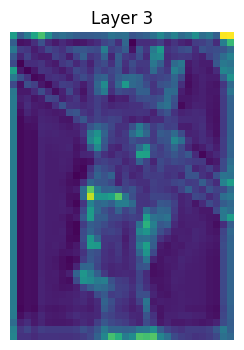

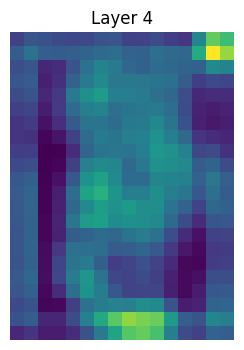

In [70]:
import matplotlib.pyplot as plt

def plot_heatmap(features):
    with torch.no_grad():
        for i, f in enumerate(features):
            plt.figure(figsize=(4, 4))
            plt.imshow(f.squeeze().mean(0), cmap='viridis')  # усредняем карты признаков по каналам
            # if hasattr(f, 'conv1'):  # проверяем, является ли объект f сверточным блоком
            #     plt.imshow(f.conv1.weight.mean(0), cmap='viridis')
            # elif hasattr(f, 'conv2'):
            #     plt.imshow(f.conv2.weight.mean(0), cmap='viridis')
            # else:  # если это не сверточный блок, то это тензор (последний слой)
            #     plt.imshow(f.mean(0), cmap='viridis')
            plt.title(f'Layer {i}')
            plt.axis('off')
            plt.show()

plot_heatmap(features)

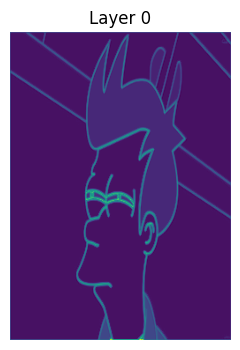

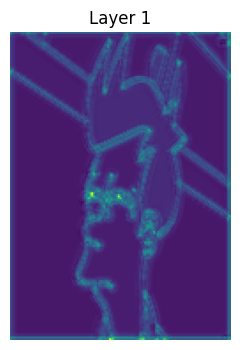

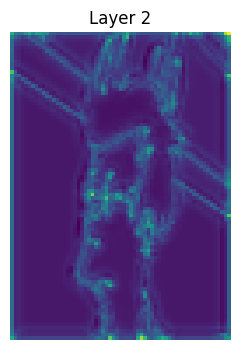

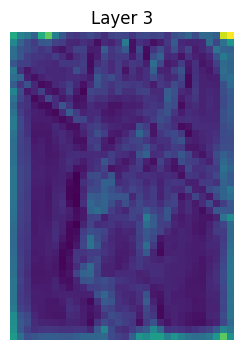

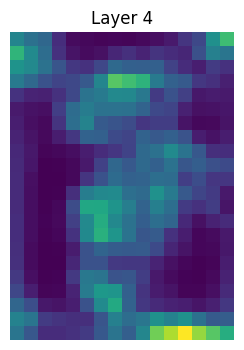

In [71]:
#resnet34
model = timm.create_model('resnet34', pretrained=True, features_only=True)
features = model(img_tensor.unsqueeze(0))
plot_heatmap(features)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rsb-weights/resnet50_a1_0-14fe96d1.pth" to /home/noble6/.cache/torch/hub/checkpoints/resnet50_a1_0-14fe96d1.pth


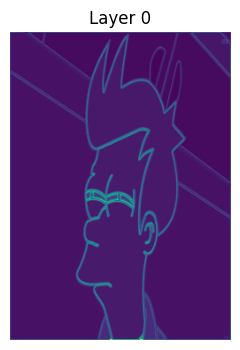

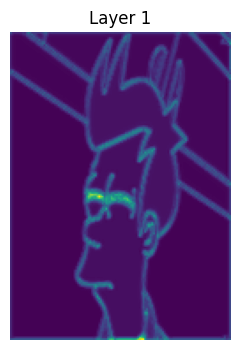

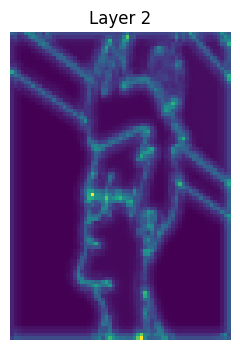

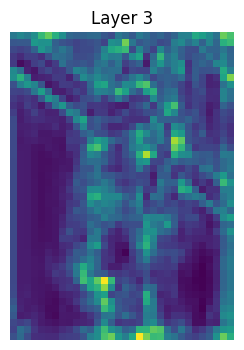

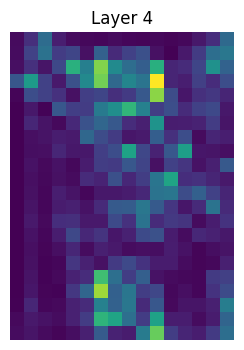

In [72]:
#resnet50
model = timm.create_model('resnet50', pretrained=True, features_only=True)
features = model(img_tensor.unsqueeze(0))
plot_heatmap(features)

## Pytorch Lighnting

Обертка над PyTorch, главная цель - автоматизация шаблонного кода, позволяющая концентрироваться на важных вещах

https://lightning.ai/docs/pytorch/stable/starter/introduction.html

Фишки:

- Удобный интерфейс классов для определения логики моделей и обучения
- Автоматизация model.train(), model.eval(), requires_grad, precision чисел
- Сохранение чекпоинтов в формате TensorBoard
- Удобный вывод информации о модели: количество замороженных/обучаемых параметров, наличие GPU
- Удобный расчет метрик
- Множество трюков для улучшения обучения, которые просто включить

## Inductive bias

Подробнее: https://habr.com/ru/post/591779/

Суть - ограничения модели на самом деле хорошо, главное уметь применить

Линейная регрессия хороша, когда вы понимаете, что она соотносится с вашей задачей + она требует меньше данных, чем более гибкая модель.

Схожая ситуация со свертками - в операцию уже вшиты assumptions о структуре входных данных, и модели нужно меньше данных для обучения, чем, например, для трансформеров

# Лабораторная работа

### Решить задачу классификации в датасете Fashion MNIST, используя предобученный resnet18 и PyTorch Lightning (политику заморозки выбирать самим)
1. Определить модель со всеми нужными методами (для тренировки и тестирования)
2. Обучить модель.
3. Вывести график функции потерь по эпохам. 
4. Используя тестовое множество

  * Продемонстрировать работу модели: вывести несколько изображений, указать над ними правильный класс и класс, предсказанный моделью. 

  * Вывести матрицу ошибок.

  * Вывести значение accuracy и f1 на тестовом множестве (обе метрики >= 0.7).

* Сохранить модель

### Dataset

In [27]:
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms

data_transform = transforms.Compose([
    # transforms.Resize((28 * 3, 28 * 3)),
    # transforms.RandomHorizontalFlip(),
    # transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),  # изменение яркости, контраста, насыщенности и тона
    transforms.ToTensor(),  # преобразование изображения в тензор
    transforms.Normalize((0.5), (0.5))  # нормализуем значения
])

data_path = './data/fmnist'
train_dataset = datasets.FashionMNIST(data_path, train=True, download=True, transform=data_transform)
test_dataset = datasets.FashionMNIST(data_path, train=False, download=True, transform=data_transform)

num_classes = len(datasets.FashionMNIST.classes)



train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [28]:
test_dataset[0][0].shape

torch.Size([1, 28, 28])

### Модель

In [29]:
# <YOUR CODE>
from torchvision.models import resnet18
import torch
import torchmetrics
import torch.nn as nn
import torch.optim as optim
import pytorch_lightning as pl
from sklearn.metrics import f1_score
from torch.optim.lr_scheduler import ReduceLROnPlateau


class FMNISTResNet(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.num_classes = num_classes
        self.resnet = resnet18(pretrained=True)
        # Принимаем 1-канальные изображения
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        # заморозка
        # for param in self.resnet.parameters():
        #     param.requires_grad = False
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, 10)

    def forward(self, x):
        return self.resnet(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = nn.CrossEntropyLoss()(logits, y)
        self.log('train_loss', loss)
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.resnet.parameters(), lr=0.01)
        return {
        "optimizer": optimizer,
        "lr_scheduler": {
            "scheduler": ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True),
            "monitor": "train_loss",
        },
    }
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = nn.CrossEntropyLoss()(logits, y)
        self.log('val_loss', loss)
        preds = torch.argmax(logits, dim=1)
        accuracy = torch.sum(preds == y).item() / (len(y) * 1.0)
        # torch.metric
        f1 =f1_score(preds.detach().cpu(), y.detach().cpu(), average="macro")
        self.log('val_accuracy', accuracy, prog_bar=True)
        self.log('val_f1', f1, prog_bar=True)



In [30]:
from pytorch_lightning.loggers import CSVLogger

# Лог метрик
csv_logger = CSVLogger('logs', name='fmnist_resnet')

### Train

In [31]:
model = FMNISTResNet()

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Количество обучаемых параметров: {total_params}")

/home/noble6/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/noble6/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Количество обучаемых параметров: 11175370


In [22]:
trainer = pl.Trainer(max_epochs=5, accelerator="gpu", logger=[csv_logger])
trainer.fit(model, train_dataloader, test_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/noble6/.local/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:613: UserWarning: Checkpoint directory logs/fmnist_resnet/version_22/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type   | Params
----------------------------------
0 | resnet | ResNet | 11.2 M
----------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.701    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/noble6/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/noble6/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 00005: reducing learning rate of group 0 to 5.0000e-03.


In [23]:
# Финальные метрики
trainer.callback_metrics

{'train_loss': tensor(0.2187),
 'val_loss': tensor(0.2519),
 'val_accuracy': tensor(0.9092),
 'val_f1': tensor(0.9015, dtype=torch.float64)}

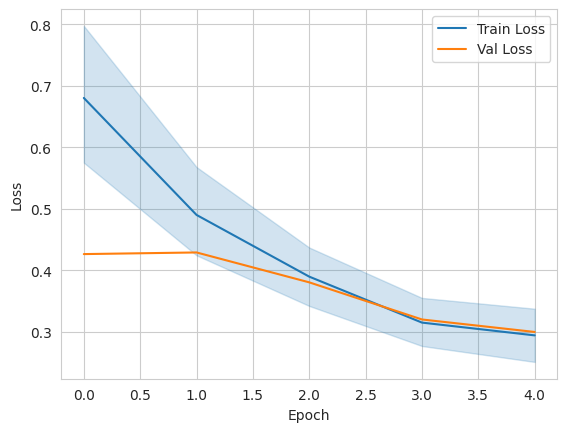

In [46]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

logs = pd.read_csv('logs/fmnist_resnet/version_23/metrics.csv')

sns.set_style("whitegrid")

sns.lineplot(data=logs, x='epoch', y='train_loss', label='Train Loss')
sns.lineplot(data=logs, x='epoch', y='val_loss', label='Val Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [25]:
from sklearn.metrics import accuracy_score

# Проверка на тестовом множестве
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    y_true = []
    y_pred = []
    for images, labels in test_dataloader:
        outputs = model(images)
        
        # Выбираем класс с наибольшей вероятностью
        max_values, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.detach().cpu()) 
        y_pred.extend(predicted.detach().cpu())
        

    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average="macro")

    print(f'Test Accuracy: {acc}')
    print(f'Test F1 Score: {f1}')


Test Accuracy: 0.9092
Test F1 Score: 0.9095927500942566


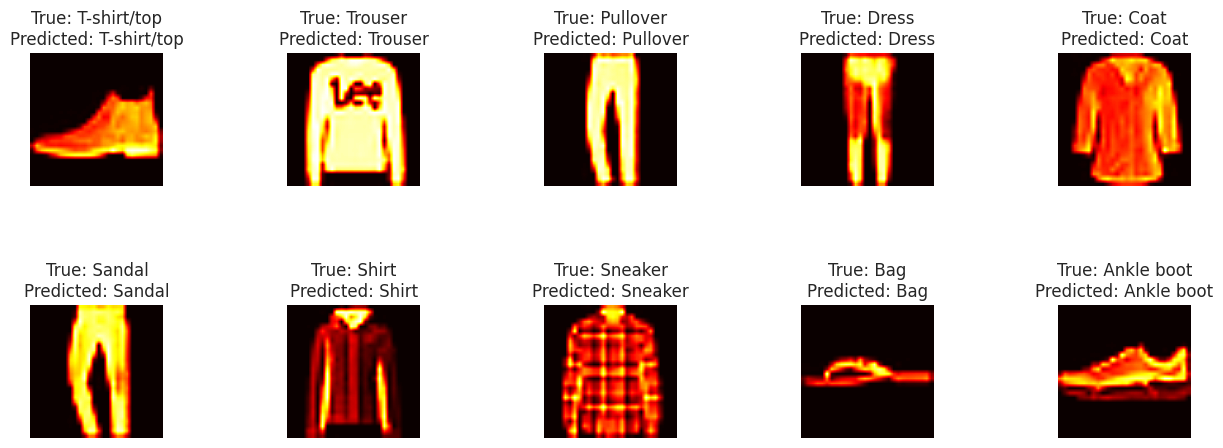

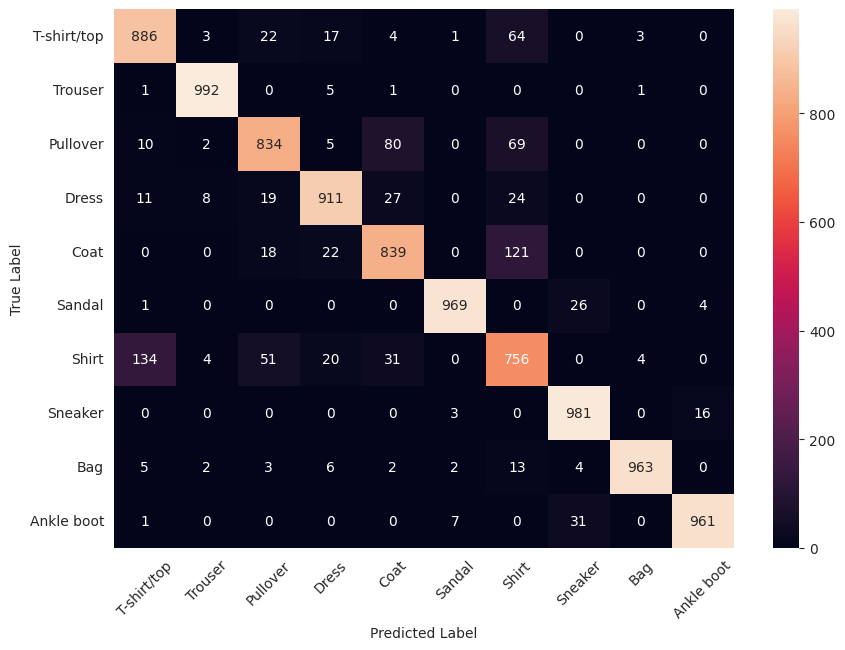

In [26]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

images, labels = next(iter(test_dataloader))

outputs = model(images)
_, predicted = torch.max(outputs.data, 1)

fig, axs = plt.subplots(2, 5, figsize=(15, 5))
fig.subplots_adjust(hspace=0.9, wspace=0.9)

for i in range(2):
    for j in range(5):
        axs[i,j].imshow(images[j+i*5][0], cmap="hot")
        axs[i,j].set_title(f'True: {train_dataset.classes[j+i*5]}\nPredicted: {train_dataset.classes[j+i*5]}')
        axs[i,j].axis('off')

# Вывод матрицы ошибок
y_true = []
y_pred = []
with torch.no_grad():
    correct = 0
    total = 0
    
    for images, labels in test_dataloader:
        images = images
        labels = labels
        outputs = model(images)
                
        max_values, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.detach().cpu()) 
        y_pred.extend(predicted.detach().cpu())

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g')
plt.xticks(np.arange(10)+0.5, train_dataset.classes, rotation=45)
plt.yticks(np.arange(10)+0.5, train_dataset.classes, rotation=0)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

#### Выводы
Лучшие показатели точности:
1. 65% с заморозкой всех весов, кроме последнего слоя, размер не меняли (28*28)
2. 88% без заморозки весов, ReduceLROnPlateau, размер не меняли (28*28), нормализация (0.5, 0.5)
3. 91% без заморозки весов, ReduceLROnPlateau, увеличили изображение в 3 раза (84*84), нормализация (0.5, 0.5)